### Modules

In [5]:
import tensorflow_addons as tfa
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense,Input,GlobalAveragePooling2D,AveragePooling2D
import datetime
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Data Demo

In [43]:
def standardize(image_data):
        image_data -= np.mean(image_data)
        image_data /= np.std(image_data)
        return image_data


img_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.9999, rescale = 1./255)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.0001, rescale = 1.0/255)
data_dir = '../e4040-proj-data/'

cat_name = ['airplane', '']


airplane = data_dir + 'airplane'

training_airplane = img_gen.flow_from_directory(airplane, subset = 'training' , shuffle = True, 
                                        class_mode = 'binary')
validation = val_gen.flow_from_directory(airplane, subset = 'validation' , shuffle = True, 
                                         class_mode = 'binary')

gen = itertools.chain(validation, training_airplane)


Found 4 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


## Data Playground

In [49]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.9, rescale = 1./255)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.1, rescale = 1.0/255)
data_dir = '../e4040-proj-data/'
training_airplane = img_gen.flow_from_directory(data_dir, subset = 'training' , shuffle = True, 
                                        class_mode = 'binary', classes = ['0_real', '1_fake'])

Found 0 images belonging to 2 classes.


## Visualization

[1. 0.]


IndexError: index 2 is out of bounds for axis 0 with size 2

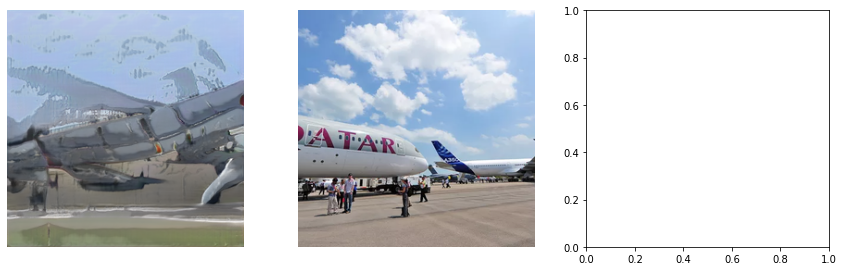

In [45]:
#pic size 256*256*3
a,  b = next(gen)
print(b)
fig = plt.figure(figsize=(20,20))

for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(a[i,:].reshape(256,256,3))
    ax.axis('off')

[1. 0.]


IndexError: index 2 is out of bounds for axis 0 with size 2

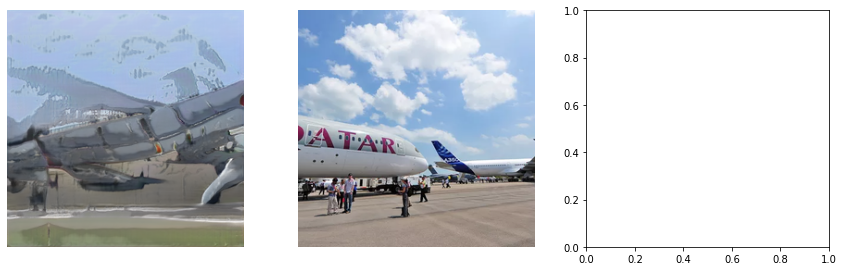

In [3]:
c = a[16:]
d = b[16:]

### Hand-Craft ResNet-18

In [6]:
from Network.ResNet import ResNet
import tensorflow_addons as tfa
model = ResNet([2,2,2,2])
model.build(input_shape=(None, 256, 256,3))

### ResNet-18 Demo

In [ ]:
optimizer = tf.optimizers.SGD(lr=1e-4)
loss=tf.keras.losses.BinaryCrossentropy(from_logits = True)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.summary()
model.fit(training, epochs=30, batch_size=256)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

113/113 [==============================] - 19s 165ms/step - loss: 0.4424 - accuracy: 0.7465
Epoch 2/30
113/113 [==============================] - 19s 166ms/step - loss: 0.4208 - accuracy: 0.7671
Epoch 3/30
113/113 [==============================] - 19s 167ms/step - loss: 0.4101 - accuracy: 0.7826
Epoch 4/30
113/113 [==============================] - 19s 168ms/step - loss: 0.4005 - accuracy: 0.7821
Epoch 5/30
113/113 [==============================] - 19s 169ms/step - loss: 0.3945 - accuracy: 0.7876
Epoch 6/30
113/113 [==============================] - 19s 169ms/step - loss: 0.3887 - accuracy: 0.7946
Epoch 7/30
113/113 [==============================] - 19s 170ms/step - loss: 0.3760 - accuracy: 0.8032
Epoch 8/30
113/113 [==============================] - 19s 171ms/step - loss: 0.3714 - accuracy: 0.8057
Epoch 9/30
113/113 [==============================] - 19s 171ms/step - loss: 0.3730 - accuracy: 0.8051
Epoch 10/30
113/113 [==============================] - 19s 171ms/step - loss: 0.3654

### ResNet-50 from Keras

In [4]:
# Transfer Learning - Tryouts

base_model = applications.ResNet50(weights='imagenet', include_top=False)  
#base_model = applications.xception.Xception(weights='imagenet', include_top=False, input_shape=[resize_H,resize_W,channel]) 

for layer in base_model.layers[:140]:  # Keep the pretrained params
    layer.trainable = False
for layer in base_model.layers[140:]:  # Keep the pretrained params
    layer.trainable = True
    
x = base_model.output  # 
x = GlobalAveragePooling2D()(x)  
# x = Dense(1024, activation='relu', name='fc1',kernel_regularizer=keras.regularizers.l2(0.0001))(x)  
# x = Dropout(0.5)(x)  # Droupout 0.6
# x = Dense(512, activation='relu', name='fc2',kernel_regularizer=keras.regularizers.l2(0.0001))(x)
# #x = Dropout(0.5)(x)
predictions = Dense(1, name='predictions')(x)  

model = Model(base_model.input,predictions)  

### Hyperparameters

In [5]:
#optimizer = tfa.optimizers.AdamW(lr=3e-4, weight_decay=3e-4)
optimizer = tf.optimizers.Adam(lr = 1e-4)
loss=tf.keras.losses.BinaryCrossentropy(from_logits = True)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Tranining Strategies and Implementation

In [9]:
#reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, mode='auto')
#early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='auto')
#model.fit(a, b, epochs=30, shuffle = True, batch_size = 64, callbacks=[reduce, early])
model.fit(training, validation_data = validation, epochs=30, shuffle = True, batch_size = 256, steps_per_epoch = 14)

Epoch 1/30
14/14 [==============================] - 11s 817ms/step - loss: 0.5258 - accuracy: 0.6987 - val_loss: 1.0788 - val_accuracy: 0.5017
Epoch 2/30
14/14 [==============================] - 11s 791ms/step - loss: 0.5139 - accuracy: 0.6853 - val_loss: 0.8484 - val_accuracy: 0.5378
Epoch 3/30
14/14 [==============================] - 11s 785ms/step - loss: 0.5157 - accuracy: 0.7188 - val_loss: 0.9808 - val_accuracy: 0.5206
Epoch 4/30
14/14 [==============================] - 11s 783ms/step - loss: 0.4802 - accuracy: 0.7210 - val_loss: 1.4266 - val_accuracy: 0.5061
Epoch 5/30
14/14 [==============================] - 11s 773ms/step - loss: 0.4880 - accuracy: 0.7366 - val_loss: 1.1620 - val_accuracy: 0.5172
Epoch 6/30
14/14 [==============================] - 11s 775ms/step - loss: 0.5463 - accuracy: 0.6959 - val_loss: 1.2962 - val_accuracy: 0.4950
Epoch 7/30
14/14 [==============================] - 11s 780ms/step - loss: 0.4790 - accuracy: 0.7478 - val_loss: 1.0099 - val_accuracy: 0.5094

KeyboardInterrupt: 